In [315]:
# Imports
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress



In [316]:

BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_main_image = cv2.cvtColor(new_main_image, cv2.COLOR_BGR2RGB)
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image

def display_disp_image(to_be_displayed, title="Image", d_type="turbo"):
    plt.figure(figsize=(10, 6))
    plt.imshow(to_be_displayed, cmap=d_type)
    plt.title(title)
    plt.show()

def display_columns_on_image(input_image, col_indices=[500]):
    to_be_displayed = input_image.copy()
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = to_be_displayed.shape[0]
    width = to_be_displayed.shape[1]

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        to_be_displayed = cv2.line(to_be_displayed, (col_indices[index],0), (col_indices[index], height), colour, 3)
        #original_image = cv2.line(original_image, dimStart, dimSlutt, colour, 1)


    display_disp_image(to_be_displayed)


# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Båt =  1689068854381001093
# Fra blanda
KajakkOgBåt = 1689068879500907093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)

standard_fig_size = (10, 6)


Første: 1689072633388130541  Nærme:  1689072600363349541


In [317]:

def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        return column

    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(input):
    dI = input.copy()
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])
    return dI

import matplotlib.colors as mcolors

def generate_dark_colors(n):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    
    return colors

def disparity_graphing(disp_map, col_indices=[500], display=False, invert=False):
    
    colours = ['red', 'green', 'blue']

    plt.figure(figsize=standard_fig_size)
    # Extract and plot each column


    for i, col in enumerate(col_indices):
            if(col > disp_map.shape[1]):
                col_indices.pop(i+1)

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]
        col_data = disp_map[:, col_idx]
        y_values = range(len(col_data))
        plt.plot(col_data, y_values, label=f'Column {index + 1} (Index {col_idx})', color=colour)


    title="Disparity profiles along Column(s) " + str(col_indices)

    # Invert y-axis to match image orientation
    if(invert):
        plt.gca().invert_yaxis()

    # Add labels and legend
    plt.xlabel('Disparity Value')
    plt.ylabel('V-value (rows)')
    plt.title(title)
    plt.legend()

    # Show the plot
    if(display):
        plt.show()

def display_columns_on_image(original_image, col_indices=[500]):
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = original_image.shape[0]
    width = original_image.shape[1]

    og_image = original_image.copy()

    for i, col in enumerate(col_indices):
            if(col > og_image.shape[1]):
                print("Cols popped")
                col_indices.pop(i+1)

    title="Columns on original image"


    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        og_image = cv2.line(og_image, (col_indices[index],0), (col_indices[index], height), colour, 3)


    display_disp_image(og_image)

def display_columns_on_image_V2(original_image, col_indices=[500]):
    # Use a copy of the original image to draw on
    og_image = original_image.copy()
    height = og_image.shape[0]
    width = og_image.shape[1]

    title = "Columns on Original Image"

    # Iterate over each column index you want to display
    for col_idx in col_indices:
        if col_idx >= width:
            print("Column index out of image bounds:", col_idx)
            continue

        # Iterate over each pixel in the specified column
        for row in range(height):
            # Calculate the brightness of the current pixel
            pixel = og_image[row, col_idx]
            brightness = 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]

            # Choose the line color based on the pixel brightness
            if brightness < 128:  # Dark pixel, make the line white
                line_color = (255, 255, 255)
            else:  # Light pixel, make the line black
                line_color = (0, 0, 0)

            # Set the pixel color on the image
            og_image[row, col_idx] = line_color

    # Display the modified image
    display_disp_image(og_image, title=title)


In [318]:
""" current_disparity_data = nærme_disparity.copy()
current_image = nærme_image.copy()
interpolate_each_column(current_disparity_data)
display_disp_image(current_image, "Original Image")
#display_disp_image(current_disparity_data, "Interpolated Disparity Image") """

' current_disparity_data = nærme_disparity.copy()\ncurrent_image = nærme_image.copy()\ninterpolate_each_column(current_disparity_data)\ndisplay_disp_image(current_image, "Original Image")\n#display_disp_image(current_disparity_data, "Interpolated Disparity Image") '

In [319]:
plot_initial_images = False
testing_image = False

if(testing_image):
    # Testing image
    current_original_image = nærme_image
    current_disparity_data = nærme_disparity
    curr_col = [1250]
    display_columns_on_image(current_original_image, curr_col)
    display_columns_on_image_V2(current_original_image, curr_col)
    disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
 


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    display_columns_on_image(nærme_image, cols_nærme)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)


    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    display_columns_on_image(første_image, cols_første)
    disparity_graphing(første_disparity, cols_første, display=True, invert=False)
    disparity_graphing(første_disparity, cols_første, display=True, invert=True)


    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    display_columns_on_image(badering_første_image, cols_badering)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)

    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    display_columns_on_image(badering_mann_image, cols_mann)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)

    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    display_columns_on_image(båt_image, cols_båt)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)

    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    
    
    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    display_columns_on_image(båt_bak_image, cols_båtBak)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)

    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    display_columns_on_image(båt_fram_image, cols_båtFram)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

dI = nærme_disparity
original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image




Diff method


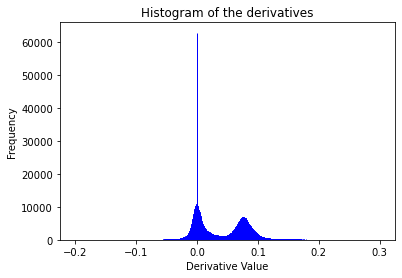

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


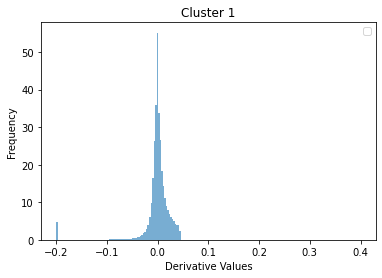

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


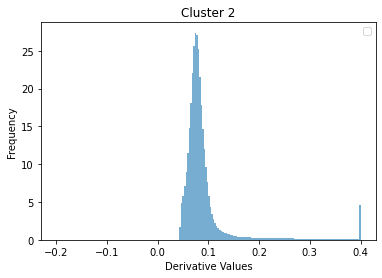

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


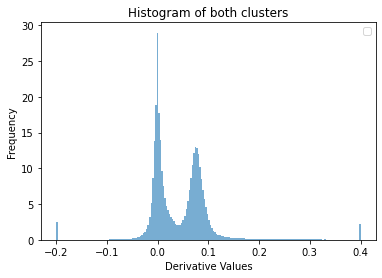

In [320]:
from scipy.special import binom

n = 30  # Length of the kernel
kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

# Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_binomial):
    # Apply convolution
    filtered_column = np.convolve(column, K, mode='same')
    return filtered_column

# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()

    if(plot):
        # Plot the histogram
        plt.figure()
        plt.hist(flattened_derivatives, bins=input_bins, range=(-0.2,0.3), color='blue', edgecolor='blue')
        plt.title(title)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return flattened_derivatives

def apply_low_pass_filter(dI, K=kernel_binomial):
    
    height, width = dI.shape
    df = np.zeros_like(dI)  # Low-pass filtered disparity image
    for x in range(width):
        df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial)

    return df

def take_derivative_diff(df):
    print("Diff method")

    # Computing the derivative of each column
    df_derivative = np.diff(df, axis=0)

    # Padding to handle size difference after np.diff
    df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')

    return df_derivative



def take_derivative_sobel(df, normalize=True):
    print("Sobel method")  

    # Define the 1D Sobel kernelS
    kernel_m = np.array([1, 0, -1])

    # Initialize an array to store the vertical derivative image
    vertical_derivative = np.zeros_like(df)

    # Apply the Sobel kernel to each column
    if(normalize):
        for i in range(df.shape[1]):  # Iterate over columns
            vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2 
    else:
        for i in range(df.shape[1]):  # Iterate over columns
            vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same')

    return vertical_derivative


## Clustering



def clustering(flattened_derivatives, a_mini=-0.2, a_maxi=0.4, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init='auto')
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

def plot_clusters(clustering_model):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]

    plt.figure()
    plt.hist(cluster1, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 1')
    plt.legend()
    plt.show()

    # Plot histogram 
    plt.figure()
    plt.hist(cluster2, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 2')
    plt.legend()
    plt.show()

    plt.figure()
    plt.hist(clustering_model, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of both clusters')
    plt.legend()
    plt.show()

# Gaussian fit function
def fit_gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev

def fit_clusters(clustering_model):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]
    mean1, stddev1 = fit_gaussian(cluster1)
    mean2, stddev2 = fit_gaussian(cluster2)

    return mean1, mean2, stddev1, stddev2

    

def gaussian_curve(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)




# Interpolate
dI = interpolate_each_column(dI)

# Low-pass filter
df = apply_low_pass_filter(dI)

# Take the derivative
df_derivative = take_derivative_diff(df)
#df_derivative = take_derivative_sobel(df, normalize=False)

# Flatten the derivatives for clustering
flattened_derivatives = flatten_and_plot_histogram(df_derivative, title="Histogram of the derivatives")

# Clustering
clustering_model, clipped_derivatives, labels, centers = clustering(flattened_derivatives)

# Plot the clusters
plot_clusters(clustering_model)



0  Mean:  [0.06322211]  Standard Deviation:  [[0.06600325]]
1  Mean:  [-1.99800669e-05]  Standard Deviation:  [[0.00681728]]
Mean1:  -0.00032721506  Mean2:  0.090145014
Stddev1:  0.02944064  Stddev2:  0.052985024


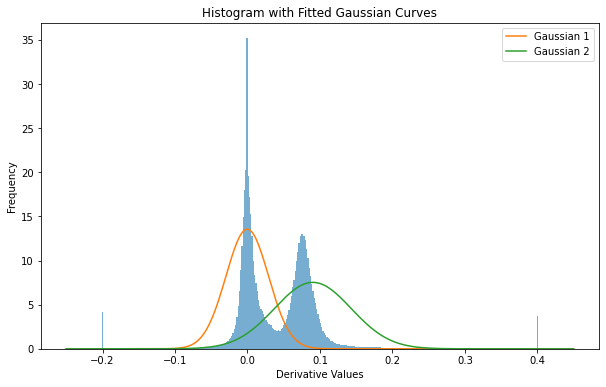

" # Plot histogram and Gaussian curves\nplt.figure()\nplt.hist(clipped_derivatives, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)\nplt.plot(x_values, gaussian_curve1, label='Gaussian 1')\nplt.plot(x_values, gaussian_curve2, label='Gaussian 2')\nplt.xlabel('Derivative Values')\nplt.ylabel('Frequency')\nplt.title('Histogram with Fitted Gaussian Curves')\nplt.legend()\nplt.show()\n\n# Plot histogram and Gaussian curves\nplt.figure()\nplt.hist(clipped_derivatives, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)\nplt.plot(x_values, gaussian_curve1, label='Gaussian 1')\nplt.plot(x_values, gaussian_curve2, label='Gaussian 2')\nplt.xlabel('Derivative Values')\nplt.ylabel('Frequency')\nplt.title('Histogram with Fitted Gaussian Curves')\nplt.legend()\nplt.show() "

In [329]:
from sklearn.mixture import GaussianMixture




multimodal_dist = np.clip(flattened_derivatives, -0.2, 0.4)

gmm = GaussianMixture(n_components=2)
gmm.fit(multimodal_dist.reshape(-1, 1))

means = gmm.means_

# Conver covariance into Standard Deviation
standard_deviations = gmm.covariances_**0.5  

# Useful when plotting the distributions later
weights = gmm.weights_  


#print(f"Means: ", means) 
#print("Standard Deviations: ",standard_deviations)
for i in range(len(means)):
    print(i, " Mean: ", means[i], " Standard Deviation: ", standard_deviations[i])


# Gaussian mixtures
# Fit Gaussian to each cluster
""" mean1 = means[0][0]
mean2 = means[1][0]
stddev1 = standard_deviations[0][0][0]
stddev2 = standard_deviations[1][0][0] """

# Regular "Bad looking gaussian"
""" mean1, stddev1 = fit_gaussian(cluster1)
mean2, stddev2 = fit_gaussian(cluster2)
"""
mean1, mean2, stddev1, stddev2 = fit_clusters(clustering_model)

#mean2 = 0.078
#stddev2 = 0.01

print("Mean1: ", mean1, " Mean2: ", mean2)
print("Stddev1: ", stddev1, " Stddev2: ", stddev2)
#mean2 = 0.07

# Determine which mean is closer to 0 and assign labels
if abs(mean1) < abs(mean2):
    red_mean, green_mean = mean1, mean2
    red_stddev, green_stddev = stddev1, stddev2
    red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
else:
    red_mean, green_mean = mean2, mean1
    red_stddev, green_stddev = stddev2, stddev1
    red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'

# Below are the upper and lower bounds
# Assuming you have mean1, stddev1, mean2, stddev2 from the Gaussian fits
k = 1# Adjust this constant as needed

""" shift_amount = 0.02  # Adjust this value to shift the curve to the left
# Adjust mean2 for Gaussian Curve 2
adjusted_mean2 = mean2 - shift_amount
mean2 = mean2 - shift_amount 
#gaussian_curve2Adjust = gaussian(x_values, adjusted_mean2, stddev2)
"""

# Calculate range limits for each Gaussian curve
dL1 = mean1 - k * stddev1
dU1 = mean1 + k * stddev1
dL2 = mean2 - k * stddev2
dU2 = mean2 + k * stddev2

red_dL = red_mean - k * red_stddev
red_dU = red_mean + k * red_stddev
green_dL = green_mean - k * green_stddev
green_dU = green_mean + k * green_stddev


# Create a range of x values
x_values = np.linspace(-0.25, 0.45, 400)

# Gaussian curves
gaussian_curve1 = gaussian_curve(x_values, mean1, stddev1)
gaussian_curve2 = gaussian_curve(x_values, mean2, stddev2)

# Plot histogram and Gaussian curves
plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=400, range=(-0.25, 0.45), density=True, alpha=0.6)
plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

""" # Plot histogram and Gaussian curves
plt.figure()
plt.hist(clipped_derivatives, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

# Plot histogram and Gaussian curves
plt.figure()
plt.hist(clipped_derivatives, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show() """

includes undecided
[[ 0.8916211   0.8905363   0.89118147 ...  0.5956156   0.6194196
   0.64230895]
 [ 0.7860341   0.78439856  0.7840922  ...  0.49274325  0.5084293
   0.52445817]
 [ 0.61000395  0.6076908   0.6062083  ...  0.33962965  0.34499645
   0.3520701 ]
 ...
 [-5.0012703  -5.0022087  -5.001194   ... -4.780205   -4.782257
  -4.7796326 ]
 [-6.616516   -6.6121635  -6.604313   ... -6.281704   -6.284729
  -6.285015  ]
 [-6.616516   -6.6121635  -6.604313   ... -6.281704   -6.284729
  -6.285015  ]]
[['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ...
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']]


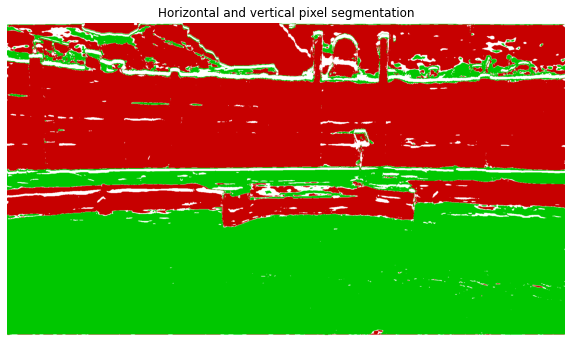

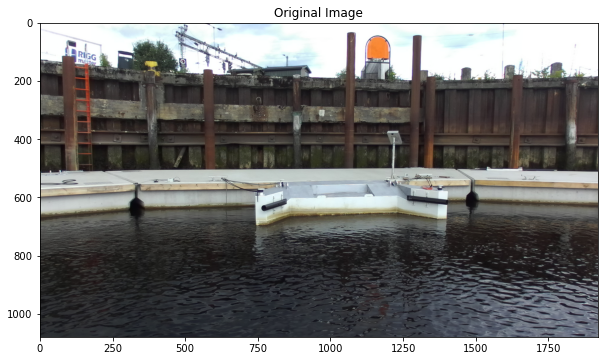

In [331]:
# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
classification_map = np.empty(df_derivative.shape, dtype=object)

include_undecided_label = True

if include_undecided_label:
    print("includes undecided")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                classification = 'undecided'
            elif red_dL <= derivative_value <= red_dU:
                classification = 'upright'  # Red cluster
            elif green_dL <= derivative_value <= green_dU:
                classification = 'horizontal'  # Green cluster
            else:
                classification = 'unknown'

            classification_map[i, j] = classification
else:
    print("Undecided and unknown is the same")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                classification = 'unknown'
            elif red_dL <= derivative_value <= red_dU:
                classification = 'upright'  # Red cluster
            elif green_dL <= derivative_value <= green_dU:
                classification = 'horizontal'  # Green cluster
            else:
                classification = 'unknown'

            classification_map[i, j] = classification

print(df_derivative)
print(classification_map)

# Dark color definitions with brightness < 128/256
Dark_Red = [100/256, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 100/256]  # Deep blue, similar to navy
Dark_Green = [0, 100/256, 0]  # Deep green
Bright_Red = [200/256, 0, 0]  # Bright red
Bright_Green = [0, 200/256, 0]  # Bright green
Bright_Blue = [0, 0, 200/256]  # Bright blue
Dark_Yellow = [128/256, 128/256, 0]  # Muted yellow, darkened
Dark_Purple = [75/256, 0, 130/256]  # Similar to indigo, dark purple
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/256, 139/256]  # Rich cyan, darkened
Dark_Magenta = [139/256, 0, 139/256]  # Deep magenta
Charcoal_Gray = [50/256, 50/256, 50/256]  # Dark gray, akin to charcoal
Dark_Lime = [50/256, 205/256, 50/256]  # A darker shade of lime green
Dark_Pink = [255/256, 20/256, 147/256]  # Deep pink, darkened
Dark_Olive = [85/256, 107/256, 47/256]  # Muted, darker olive green
Dark_Turquoise = [0, 206/256, 209/256]  # Deep turquoise
Dark_Brown = [165/256, 42/256, 42/256]  # A rich, dark brown
Dark_Goldenrod = [184/256, 134/256, 11/256] # Dark goldenrod
White = [1, 1, 1]  # White
Dark_gray = [0.2,0.2,0.2]

colorScheme = {
    'horizontal1': Bright_Green,
    'horizontal2': Bright_Blue,
    'horizontal3': Dark_Green,
    'horizontal4': Dark_Brown,
    'horizontal5': Dark_Blue,
    'horizontal6': Charcoal_Gray,  # Custom darker teal
    'horizontal7': Dark_Lime,  # Custom dark leaf green
    'vertical1': Bright_Red,
    'vertical2': Dark_Magenta,
    'vertical3': Dark_Yellow,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': White,  # White
    'undecided': White,  # White
    'upright': Bright_Red,
    'horizontal': Bright_Green
}


def assign_colours_and_plot(classification_map, colors=colorScheme, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()



# Nærme
#display_disp_image(nærme_image)
# Båt
#display_disp_image(båt_test_bilde)
assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation")
display_disp_image(original_image, title="Original Image")

Gaussian 1: Mean = -1.9679227617767146e-05 , Standard Deviation = 0.0068180227107736335
Gaussian 2: Mean = 0.06322374072851795 , Standard Deviation = 0.06600341843999986


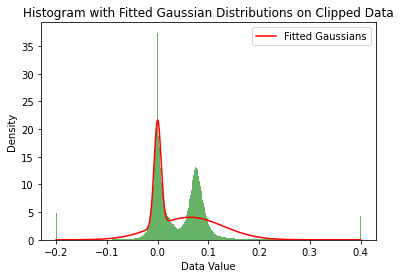

In [301]:
# Assuming 'flattened_derivatives' is your original dataset
# flattened_derivatives = ...
from sklearn.mixture import GaussianMixture

# Clip the data to be within -0.3 and 0.6
clipped_derivatives = np.clip(flattened_derivatives, -0.2, 0.4)

# Fit a Gaussian Mixture Model with 2 components to the clipped data
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(clipped_derivatives.reshape(-1, 1))

# Extract the means and standard deviations of the fitted Gaussians
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()

# Print the extracted parameters
print("Gaussian 1: Mean =", means[0], ", Standard Deviation =", std_devs[0])
print("Gaussian 2: Mean =", means[1], ", Standard Deviation =", std_devs[1])

# Create a range of values for plotting the Gaussians within the clipped range
x_values = np.linspace(-0.2, 0.4, 400)
gmm_pdf = np.exp(gmm.score_samples(x_values.reshape(-1, 1)))

# Plot the histogram of the clipped data
plt.hist(clipped_derivatives, bins=400, density=True, alpha=0.6, color='g')

# Plot the PDFs of the two Gaussians
plt.plot(x_values, gmm_pdf, label='Fitted Gaussians', color='red')
plt.legend()
plt.title('Histogram with Fitted Gaussian Distributions on Clipped Data')
plt.xlabel('Data Value')
plt.ylabel('Density')

plt.show()

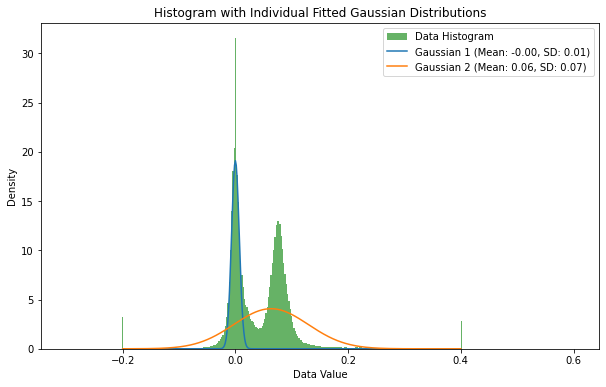

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Example flattened_derivatives - replace with your actual data
# flattened_derivatives = ...

# Clip the data between -0.3 and 0.6
clipped_derivatives = np.clip(flattened_derivatives, -0.2, 0.4)

# Fit a Gaussian Mixture Model with 2 components to the data
gmm = GaussianMixture(n_components=2, random_state=0)
#gmm = GaussianMixture(n_components=2, random_state=0, init_params='kmeans++')

gmm.fit(clipped_derivatives.reshape(-1, 1))

# Extract the means, covariances, and weights of the two Gaussians
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()

# Create a range of x values for plotting
x_values = np.linspace(-0.2, 0.4, 400)

# Calculate the individual Gaussians' PDFs
gaussian_pdfs = [
    weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))
    for i in range(2)
]

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=400, range=(-0.3, 0.6), density=True, alpha=0.6, color='g', label='Data Histogram')

# Plot each Gaussian PDF
for i, pdf in enumerate(gaussian_pdfs):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')

plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')

plt.show()


Gaussian 1: Mean = -1.9679227617767146e-05 , Standard Deviation = 0.0068180227107736335
Gaussian 2: Mean = 0.06322374072851795 , Standard Deviation = 0.06600341843999986


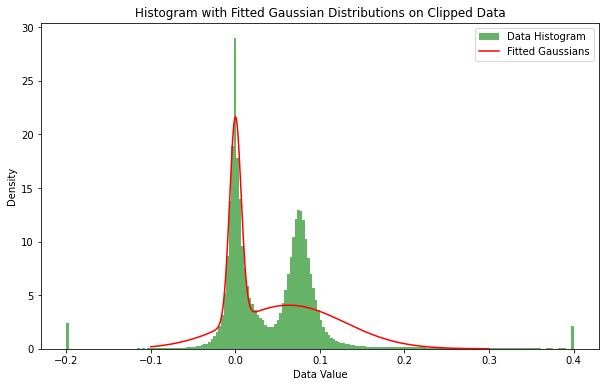

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming 'flattened_derivatives' is your dataset
# flattened_derivatives = ...

# Step 1: Clip the data between -0.2 and 0.4
clipped_derivatives = np.clip(flattened_derivatives, -0.2, 0.4)

# Step 2: Fit a Gaussian Mixture Model with 2 components to the clipped data
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(clipped_derivatives.reshape(-1, 1))

# Step 3: Extract the means and standard deviations of the fitted Gaussians
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()

# Print the extracted parameters
print("Gaussian 1: Mean =", means[0], ", Standard Deviation =", std_devs[0])
print("Gaussian 2: Mean =", means[1], ", Standard Deviation =", std_devs[1])

# Optional: Plot the histogram of the clipped data and the fitted Gaussian PDFs
# Create a range of values for plotting the Gaussians
x_values = np.linspace(-0.1, 0.3, 400)
gmm_pdf = np.exp(gmm.score_samples(x_values.reshape(-1, 1)))

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=200, density=True, alpha=0.6, color='g', label='Data Histogram')

# Plot the overall PDF of the two Gaussians
plt.plot(x_values, gmm_pdf, label='Fitted Gaussians', color='red')
plt.legend()
plt.title('Histogram with Fitted Gaussian Distributions on Clipped Data')
plt.xlabel('Data Value')
plt.ylabel('Density')

plt.show()
